# 统计复杂性等指标并绘图

### 分词算法 + Distinct指标

In [2]:
import jieba

def compute_distinct_n_tokenized(sentences, n=1):
    all_ngrams = []
    for sent in sentences:
        tokens = list(jieba.cut(sent))
        ngrams = zip(*[tokens[i:] for i in range(n)])
        all_ngrams.extend(ngrams)
    total = len(all_ngrams)
    unique = len(set(all_ngrams))
    return unique / total if total > 0 else 0

# 示例
sentences = ["患者血压为160/100mmHg，建议调整降压药。", "血压升高，考虑用药调整。", "患者血压控制不佳，需重新评估治疗方案。"]
print("Distinct-1:", compute_distinct_n_tokenized(sentences, 1))
print("Distinct-2:", compute_distinct_n_tokenized(sentences, 2))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.724 seconds.
Prefix dict has been built successfully.


Distinct-1: 0.7241379310344828
Distinct-2: 0.9615384615384616


In [ ]:
import json
import re
import random

with open('xxx', 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]
    # data = json.load(f)

def extract_json_objects(text):
    """提取所有合法JSON对象"""
    # 使用正则表达式匹配最外层大括号结构（处理换行和空格）
    pattern = r'\{[^{}]*\}'
    matches = re.findall(pattern, text, re.DOTALL)
    
    results = []
    for match in matches:
        try:
            # 清理可能的尾随逗号（处理类似 }, { 的情况）
            cleaned = match.strip().rstrip(',')
            # 转换为Python字典验证格式
            data = json.loads(cleaned)
            results.append(data)
        except json.JSONDecodeError as e:
            print(f"发现无效JSON片段：{match[:50]}... （错误信息：{e}）")
    return results

distinct_1_values = []
distinct_2_values = []

sentences_all = []
for item in data:
    sentences = extract_json_objects(item['generation'])
    sentences = [str(sentence) for sentence in sentences]  # Ensure sentences are strings
    # print("Processing sentences:", sentences)
    sentences_all.extend(sentences)

sentences_100 = random.sample(sentences_all, min(100, len(sentences_all)))
distinct_1 = compute_distinct_n_tokenized(sentences_100, 1)
distinct_2 = compute_distinct_n_tokenized(sentences_100, 2)
distinct_1_values.append(distinct_1)
distinct_2_values.append(distinct_2)

print("Distinct-1 values Avg:", sum(distinct_1_values) / len(distinct_1_values) if distinct_1_values else 0)
print("Distinct-2 values Avg:", sum(distinct_2_values) / len(distinct_2_values) if distinct_2_values else 0)

Distinct-1 values Avg: 0.14402173913043478
Distinct-2 values Avg: 0.48649324662331167


### 中文NER + 统计实体密度


In [6]:
import json

# 数据处理
def get_ref_and_gen(method):
    '''输入方法名称'''
    with open(f'../baselines/analysis/DF_Deepseek_judge_{method}_v1.jsonl', 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]

    refs = [item['rule']['answer'] for item in data if 'rule' in item and 'answer' in item['rule']]
    gens = [item['rule']['output'] for item in data if 'rule' in item and 'output' in item['rule']]
    return {
        'refs': refs,
        'gens': gens
    }

In [31]:
import jieba
import re
from collections import Counter

def tokenize(text, lang='auto'):
    """
    对中英文文本进行分词
    :param text: 输入文本
    :param lang: 语言 ('zh'中文, 'en'英文, 'auto'自动检测)
    :return: 分词后的列表
    """
    # 自动检测语言
    if lang == 'auto':
        if re.search(r'[\u4e00-\u9fff]', text):  # 检测中文字符
            lang = 'zh'
        else:
            lang = 'en'
    
    if lang == 'zh':
        # 中文分词
        return list(jieba.cut(text))
    else:
        # 英文分词: 转换为小写，分割单词，保留基本标点
        tokens = re.findall(r'\b\w+\b', text.lower())
        return tokens

def calculate_f1(ref, gen, lang='auto'):
    """
    计算F1准确率指标并统计句子长度
    :param ref: 参考文本 (标准答案)
    :param gen: 生成文本 (模型输出)
    :param lang: 语言 ('zh'中文, 'en'英文, 'auto'自动检测)
    :return: (precision, recall, f1, ref_length, gen_length) 元组
    """
    # 分词
    ref_tokens = tokenize(ref, lang)
    gen_tokens = tokenize(gen, lang)
    
    # 获取句子长度
    ref_length = len(ref_tokens)
    gen_length = len(gen_tokens)
    
    # 转换为词频计数器
    ref_counter = Counter(ref_tokens)
    gen_counter = Counter(gen_tokens)
    
    # 计算匹配的token数量
    common = ref_counter & gen_counter
    num_common = sum(common.values())
    
    # 避免除零错误
    if gen_length == 0 or ref_length == 0:
        return 0.0, 0.0, 0.0, ref_length, gen_length
    
    # 计算精确率、召回率和F1
    precision = num_common / gen_length
    recall = num_common / ref_length
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1, ref_length, gen_length

def evaluate_answers(ref_list, gen_list, lang='auto'):
    """
    批量评估答案对并统计句子长度
    :param ref_list: 参考文本列表
    :param gen_list: 生成文本列表
    :param lang: 语言
    :return: 平均F1分数、平均长度和详细结果
    """
    assert len(ref_list) == len(gen_list), "参考文本和生成文本数量必须相同"
    
    results = []
    total_f1 = 0
    total_ref_length = 0
    total_gen_length = 0
    
    for i, (ref, gen) in enumerate(zip(ref_list, gen_list)):
        p, r, f1, ref_len, gen_len = calculate_f1(ref, gen, lang)
        results.append({
            'index': i+1,
            'ref': ref,
            'gen': gen,
            'precision': round(p, 4),
            'recall': round(r, 4),
            'f1': round(f1, 4),
            'ref_length': ref_len,
            'gen_length': gen_len,
            'length_diff': gen_len - ref_len  # 生成文本与参考文本的长度差异
        })
        total_f1 += f1
        total_ref_length += ref_len
        total_gen_length += gen_len
    
    avg_f1 = total_f1 / len(ref_list)
    avg_ref_length = total_ref_length / len(ref_list)
    avg_gen_length = total_gen_length / len(ref_list)
    
    return avg_f1, avg_ref_length, avg_gen_length, results

# 中文示例
method = 'clingen'
chinese_refs = get_ref_and_gen(method)['refs']
chinese_gens = get_ref_and_gen(method)['gens']

print("中文测试结果:")
avg_f1, avg_ref_len, avg_gen_len, details = evaluate_answers(chinese_refs, chinese_gens, 'zh')
ch_ref_lengths = []
ch_gen_lengths = []
ch_f1_scores = []
for item in details:
    print(f"样本 {item['index']}:")
    print(f"  参考: '{item['ref']}' (长度={item['ref_length']})")
    ch_ref_lengths.append(item['ref_length'])
    print(f"  生成: '{item['gen']}' (长度={item['gen_length']}, 差异={item['length_diff']})")
    ch_gen_lengths.append(item['gen_length'])
    print(f"  F1={item['f1']:.4f} (P={item['precision']:.4f}, R={item['recall']:.4f})")
    ch_f1_scores.append(item['f1'])
print(f"\n平均F1分数: {avg_f1:.4f}")
print(f"平均参考长度: {avg_ref_len:.2f} 词")
print(f"平均生成长度: {avg_gen_len:.2f} 词")
print(f"平均长度差异: {avg_gen_len - avg_ref_len:.2f} 词\n")

# # 英文示例
# english_refs = [
#     "The quick brown fox jumps over the lazy dog",
#     "Natural language processing is a subfield of artificial intelligence",
#     "Deep learning models have achieved remarkable results in various tasks"
# ]

# english_gens = [
#     "A quick brown fox jumps over the lazy dog",
#     "Natural language processing is part of AI",
#     "Deep learning models get great results in many tasks"
# ]

# print("英文测试结果:")
# avg_f1, details = evaluate_answers(english_refs, english_gens, 'en')
# for item in details:
#     print(f"样本 {item['index']}: F1 = {item['f1']:.4f} (P={item['precision']:.4f}, R={item['recall']:.4f})")
# print(f"平均F1分数: {avg_f1:.4f}")

中文测试结果:
样本 1:
  参考: '预警地区A区需要进一步加强野外火源管理，开展森林防火检查，加大预警信息播报频度，做好物资调拨准备；武警森林部队对兵力部署进行必要调整，当地森林消防队伍视情靠前驻防。' (长度=46)
  生成: '预警地区A区将发布红色预警。县级以上地方人民政府将加强管理、进行巡查、增加广播、准备物资，并调整武警森林部队和当地森林消防队伍的部署。
' (长度=40, 差异=-6)
  F1=0.4884 (P=0.5250, R=0.4565)
样本 2:
  参考: '国家重大海上溢油应急处置联合指挥部会下设综合协调组、应急行动组、医疗救护组、综合保障组、信息发布与宣传组、治安保障组等，并可以派出现场工作组协助现场指挥部开展工作。' (长度=44)
  生成: '国家重大海上溢油应急处置联合指挥部将派出国家重大海上溢油应急现场工作组，并协助现场指挥部。
' (长度=24, 差异=-20)
  F1=0.5000 (P=0.7083, R=0.3864)
样本 3:
  参考: '埃博拉属于我国尚未发现传染病。' (长度=8)
  生成: '埃博拉属于我国尚未发现的传染病。
' (长度=10, 差异=2)
  F1=0.8889 (P=0.8000, R=1.0000)
样本 4:
  参考: '依据《突发公共卫生事件应急条例》及有关法律法规追究当事人的责任。' (长度=16)
  生成: '将根据《食品安全法》追究孙经理的责任。
' (长度=13, 差异=-3)
  F1=0.4138 (P=0.4615, R=0.3750)
样本 5:
  参考: '视情开展为灾区人民捐款捐物活动，加强救灾捐赠的组织发动和款物接收、统计、分配、使用、公示反馈等各环节工作。' (长度=31)
  生成: '将组织捐款捐物活动，加强救灾捐赠的组织发动和款物接收、统计、分配、使用、公示反馈等各环节工作。
' (长度=29, 差异=-2)
  F1=0.8667 (P=0.8966, R=0.8387)
样本 6:
  参考: '各级卫生行政部门要在同级人民政府或突发公共事件应急指挥机构的统一领导、指挥下，与有关部门密切配合、协调一致，共同应对突发公共事件，做好突发公共事件的医疗卫生救援工作。' (长度=42)
  生成: '国家级卫生行政部门将与国家级人民政

### GPT评估指标与B、R指标相关性

{'BLEU-4': 0.14391446616239334, 'ROUGE-1': 0.5205479402514543, 'ROUGE-2': 0.19277107937291346, 'question_understanding': 8, 'content_consistency': 7, 'coverage_of_information': 7, 'logical_coherence_and_reasonableness': 8, 'clarity_and_conciseness': 8, 'comparison_to_standard_output': 7}
{'BLEU-4': [0.4411686032511079, 0.43959898758447274, 0.5250307592600508, 0.4641515728050754, 0.3097518458969407, 0.5690075445405796], 'ROUGE-1': [0.4938982984596243, 0.4741921996525011, 0.5304681187577266, 0.5215702737860658, 0.33458471125177786, 0.6038806167430967], 'ROUGE-2': [0.3848131223176208, 0.38813045118875616, 0.4519975068132717, 0.39592195678095254, 0.2472103997769841, 0.5219187336399678]}


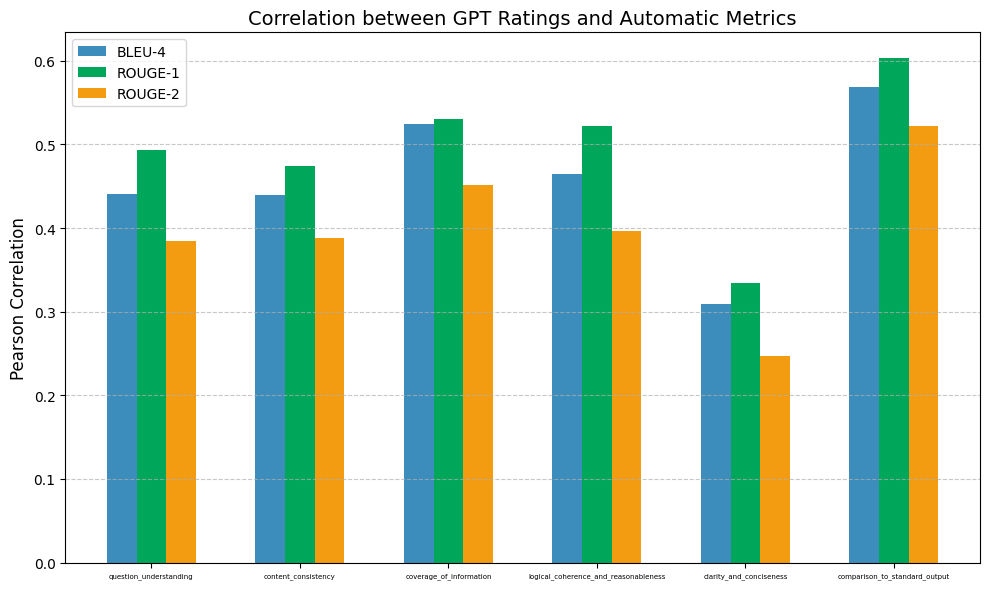

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import jieba
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_chinese import Rouge
import json

# 读取示例数据
# examples = [
#     {
#         "reference": "患者应立即增加降压药的剂量，并监测血压变化。",
#         "generated": "建议增加降压药剂量并进行血压监测。",
#         "gpt_scores": {
#             "fluency": 4.5,
#             "accuracy": 5.0,
#             "diversity": 4.2,
#             "completeness": 4.8,
#             "helpfulness": 4.7
#         }
#     },
# ]
with open('xxx', 'r', encoding='utf-8') as f:
    examples = [json.loads(line) for line in f]

# 中文BLEU、ROUGE-L计算函数
smooth = SmoothingFunction().method4

# 中文分词
def tokenize(text):
    return list(jieba.cut(text))

# 数据
data = [
    # 可添加更多样本
]

for ex in examples:
    ref = ex["rule"]["output"]
    gen = ex["rule"]["answer"]
    gpt_scores = ex["generation"].removeprefix('```json').removesuffix('```').strip()
    gpt_scores = json.loads(gpt_scores)["scores"]

    # 中文分词
    ref_tok = tokenize(ref)
    gen_tok = tokenize(gen)

    # BLEU-4
    bleu = sentence_bleu([ref_tok], gen_tok, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    
    # ROUGE-L
    rouge = Rouge()
    # 需要将分词结果转为空格分隔的字符串
    ref_str = ' '.join(ref_tok)
    gen_str = ' '.join(gen_tok)

    rouge_scores = rouge.get_scores(gen_str, ref_str)[0]  # 取第一个结果

    # 构造结果
    item = {
        "BLEU-4": bleu,
        "ROUGE-1": rouge_scores['rouge-1']['f'],
        "ROUGE-2": rouge_scores['rouge-2']['f'],
    }
    item.update(gpt_scores)
    data.append(item)

df = pd.DataFrame(data)

print(data[0])


# 计算皮尔逊相关系数
auto_metrics = ["BLEU-4", "ROUGE-1", "ROUGE-2"]
gpt_criteria = ["question_understanding", "content_consistency", "coverage_of_information", "logical_coherence_and_reasonableness", "clarity_and_conciseness", "comparison_to_standard_output"]

correlation_results = {}

for metric in auto_metrics:
    scores = []
    for gpt_item in gpt_criteria:
        corr, _ = pearsonr(df[metric], df[gpt_item])
        scores.append(corr)
    correlation_results[metric] = scores

print(correlation_results)


# 可视化：柱状图
x = range(len(gpt_criteria))
bar_width = 0.2
colors = ['#3C8DBC', '#00A65A', '#F39C12']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(auto_metrics):
    plt.bar([p + bar_width*i for p in x], correlation_results[metric],
            width=bar_width, label=metric, color=colors[i])

plt.xticks([p + bar_width for p in x], gpt_criteria, fontsize=5)
plt.ylabel("Pearson Correlation", fontsize=12)
plt.title("Correlation between GPT Ratings and Automatic Metrics", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('correlation_results_v1.pdf', format='pdf', bbox_inches='tight')

### 待定